# Промышленность — задача проекта

Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали. Вам предстоит построить модель, которая предскажет температуру стали.

## Описание этапа обработки

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. *slab*, «плита»).

## Описание данных

Данные состоят из файлов, полученных из разных источников:

- `data_arc.csv` — данные об электродах;
- `data_bulk.csv` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time.csv` *—* данные о подаче сыпучих материалов (время);
- `data_gas.csv` — данные о продувке сплава газом;
- `data_temp.csv` — результаты измерения температуры;
- `data_wire.csv` — данные о проволочных материалах (объём);
- `data_wire_time.csv` — данные о проволочных материалах (время).

Во всех файлах столбец `key` содержит номер партии. В файлах может быть несколько строк с одинаковым значением `key`: они соответствуют разным итерациям обработки.

## Первичный анализ данных

Импортируем необходимые библиотеки и загрузим данные. Посмотрим на первые строки таблиц и выведем основную информацию о них.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error as mae
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb

In [2]:
data_arc = pd.read_csv(r'C:\Users\dkiro\Desktop\проект\data_arc.csv')
data_bulk = pd.read_csv(r'C:\Users\dkiro\Desktop\проект\data_bulk.csv')
data_bulk_time = pd.read_csv(r'C:\Users\dkiro\Desktop\проект\data_bulk_time.csv')
data_temp = pd.read_csv(r'C:\Users\dkiro\Desktop\проект\data_temp.csv')
data_gas = pd.read_csv(r'C:\Users\dkiro\Desktop\проект\data_gas.csv')
data_wire = pd.read_csv(r'C:\Users\dkiro\Desktop\проект\data_wire.csv')
data_wire_time = pd.read_csv(r'C:\Users\dkiro\Desktop\проект\data_wire_time.csv')

In [3]:
# data_arc = pd.read_csv('/datasets/final_steel/data_arc.csv')
# data_bulk = pd.read_csv('/datasets/final_steel/data_bulk.csv')
# data_bulk_time = pd.read_csv('/datasets/final_steel/data_bulk_time.csv')
# data_gas = pd.read_csv('/datasets/final_steel/data_gas.csv')
# data_temp = pd.read_csv('/datasets/final_steel/data_temp.csv')
# data_wire = pd.read_csv('/datasets/final_steel/data_wire.csv')
# data_wire_time = pd.read_csv('/datasets/final_steel/data_wire_time.csv')

In [4]:
def info(df):
    display(df.head())
    display(df.info())

In [5]:
info(data_arc)

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


None

In [6]:
info(data_bulk)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


None

In [7]:
info(data_bulk_time)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:21:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:03:52,NaN,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaN,NaN,NaN,2019-05-03 11:46:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:40:20,NaN,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaN,NaN,NaN,2019-05-03 12:31:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:09:40,NaN,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,NaN,NaN,NaN,2019-05-03 12:48:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:41:24,NaN,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,NaN,NaN,NaN,2019-05-03 13:18:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:12:56,NaN,2019-05-03 13:12:56,2019-05-03 13:12:56


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


None

In [8]:
info(data_temp)

,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           15907 non-null  int64  
 1   Время замера  15907 non-null  object 
 2   Температура   13006 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB


None

In [9]:
info(data_gas)

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


None

In [10]:
info(data_wire)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


None

In [11]:
info(data_wire_time)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:46:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:13:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:48:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


None

Таблица **data_arc** содержит данные об электродах, которые нагревают сплав стали. Пропуски в данных отсутствуют, необходимо перевести столбцы *начало и конец нагрева* в тип datetime.


In [12]:
data_arc['Начало нагрева дугой'] = pd.to_datetime(data_arc['Начало нагрева дугой'])
data_arc['Конец нагрева дугой'] = pd.to_datetime(data_arc['Конец нагрева дугой'])

Таблица **data_bulk** содержит информацию об объеме поданных сыпучих материалов. Каждая строка таблицы содержит информацию об объеме каждого из материалов, поданных для конкретной партии. Соответственно, там где стоит значение NaN - материал просто не использовался. Поэтому можно заменить все значения NaN на ноль.

In [13]:
data_bulk = data_bulk.fillna(0)

Аналогично в таблице **data_bulk_time** содержится информация о том, в какое время определенный вид материала был подан в сплав. В этой таблице необходимо перевести тип данных всех значений в datetime.

In [14]:
data_bulk_time[data_bulk_time.columns[1:]] = data_bulk_time[data_bulk_time.columns[1:]].apply(pd.to_datetime)

Таблицы **data_wire** и **data_wire_time** предобработаем по той же схеме.

In [15]:
data_wire = data_wire.fillna(0)
data_wire_time[data_wire_time.columns[1:]] = data_wire_time[data_wire_time.columns[1:]].apply(pd.to_datetime)

В таблице **data_gas** все окей, оставим таблицу нетронутой. 

Посмотрим снова на таблицу **data_temp**, в ней содержится информация о замерах температуры на каждой итерации. Нам нужно только два значения для каждой партии - первое и последнее значение замеренной температуры. Температура первого замера пойдет в признаки, от нее зависит целевая переменная. А целевой переменной будет выступать как раз последняя замеренная температура для партии - именно ее мы и будем предсказывать с помощью машинного обучения. Но в данных есть пропуски и надо посмотреть, для каких именно партий они имеют место быть.

In [16]:
keys_nans = data_temp[data_temp['Температура'].isna()].key.unique() # все номера партий c пропущенной температурой 

# Выведем для наглядности первые и последние 15 номеров партий с пропусками
print('Первые 15 номеров партий с пропусками:', keys_nans[:15])
print()
print('Последние 15 номеров партий с пропусками:',keys_nans[-15:])

Первые 15 номеров партий с пропусками: [2500 2501 2502 2503 2504 2505 2506 2507 2508 2509 2510 2511 2512 2513
 2514]

Последние 15 номеров партий с пропусками: [3227 3228 3229 3230 3231 3232 3233 3234 3235 3236 3237 3238 3239 3240
 3241]


In [17]:
# Общее количество партий с пропусками в температуре
len(keys_nans)

739

In [18]:
display(data_temp.query('key == 2500'))
display(data_temp.query('key == 2501'))
display(data_temp.query('key == 3240'))
display(data_temp.query('key == 3241'))

,key,Время замера,Температура
12267,2500,2019-08-06 03:11:31,1539.0
12268,2500,2019-08-06 03:24:43,NaN
12269,2500,2019-08-06 03:25:16,NaN
12270,2500,2019-08-06 03:28:21,NaN


,key,Время замера,Температура
12271,2501,2019-08-06 03:44:42,1587.0
12272,2501,2019-08-06 04:01:59,NaN
12273,2501,2019-08-06 04:14:35,NaN
12274,2501,2019-08-06 04:22:14,NaN
12275,2501,2019-08-06 04:31:14,NaN


,key,Время замера,Температура
15894,3240,2019-09-01 02:39:01,1617.0
15895,3240,2019-09-01 02:48:33,NaN
15896,3240,2019-09-01 03:03:21,NaN
15897,3240,2019-09-01 03:12:19,NaN
15898,3240,2019-09-01 03:19:09,NaN
15899,3240,2019-09-01 03:31:27,NaN
15900,3240,2019-09-01 03:34:31,NaN
15901,3240,2019-09-01 03:35:16,NaN


,key,Время замера,Температура
15902,3241,2019-09-01 04:03:30,1586.0
15903,3241,2019-09-01 04:16:12,NaN
15904,3241,2019-09-01 04:22:39,NaN
15905,3241,2019-09-01 04:33:42,NaN
15906,3241,2019-09-01 04:38:08,NaN


Видимо, что во всех партиях с пропусками есть только первое значение. Остальных значений замеров температуры нет, в том числе нет и целевого значения. Соответственно, такие партии лучше вообще удалить из выборки и не использовать при моделировании.

In [19]:
data_temp = data_temp.query('key not in @keys_nans')

Теперь, когда мы избавились от партий с пропусками, вытащим из таблицы время первого и последнего замера температуры для каждой партии.

In [20]:
first_last_temp = pd.pivot_table(data_temp, index = 'key', values = 'Время замера', aggfunc = ['min', 'max'])
first_last_temp.columns = first_last_temp.columns.droplevel(0)
first_last_temp.reset_index(inplace = True)
first_last_temp.columns = ['key', 'Первый замер', 'Последний замер']

In [21]:
first_last_temp.head()

,key,Первый замер,Последний замер
0,1,2019-05-03 11:16:18,2019-05-03 11:30:39
1,2,2019-05-03 11:37:27,2019-05-03 11:59:12
2,3,2019-05-03 12:13:17,2019-05-03 12:34:57
3,4,2019-05-03 12:52:57,2019-05-03 12:59:25
4,5,2019-05-03 13:23:19,2019-05-03 13:36:01


Теперь добавим к таблице **first_last_temp** значения первой и последней температуры. 

In [22]:
first_temp = pd.merge(first_last_temp, data_temp.set_index('Время замера'), left_on = 'Первый замер', right_index = True, how = 'inner')
first_last_temp = pd.merge(first_temp, data_temp.set_index('Время замера'), left_on = 'Последний замер', right_index = True, how = 'inner')

first_last_temp = first_last_temp[['key', 'Первый замер', 'Температура_x', 'Последний замер', 'Температура_y']]
first_last_temp.columns = ['key', 'Первый замер', 't_first', 'Последний замер','t_last']

In [23]:
first_last_temp

,key,Первый замер,t_first,Последний замер,t_last
0,1,2019-05-03 11:16:18,1571.0,2019-05-03 11:30:39,1613.0
1,2,2019-05-03 11:37:27,1581.0,2019-05-03 11:59:12,1602.0
2,3,2019-05-03 12:13:17,1596.0,2019-05-03 12:34:57,1599.0
3,4,2019-05-03 12:52:57,1601.0,2019-05-03 12:59:25,1625.0
4,5,2019-05-03 13:23:19,1576.0,2019-05-03 13:36:01,1602.0
...,...,...,...,...,...
2472,2495,2019-08-06 00:35:45,1570.0,2019-08-06 00:54:42,1591.0
2473,2496,2019-08-06 01:02:54,1554.0,2019-08-06 01:29:52,1591.0
2474,2497,2019-08-06 01:41:53,1571.0,2019-08-06 01:53:50,1589.0
2475,2498,2019-08-06 02:03:49,1591.0,2019-08-06 02:25:31,1594.0


Проверим переменные на выбросы. Начнем с таблцы **data_arc**.

In [24]:
data_arc[['Активная мощность', 'Реактивная мощность']].describe()

,Активная мощность,Реактивная мощность
count,14876.000000,14876.000000
mean,0.670441,0.452592
std,0.408159,5.878702
min,0.030002,-715.504924
25%,0.395297,0.290991
50%,0.555517,0.415962
75%,0.857034,0.637371
max,3.731596,2.676388


Есть очевидный выброс -715 у реактивной мощности. Посмотрим на бокс-плоты для переменных без этого значения.

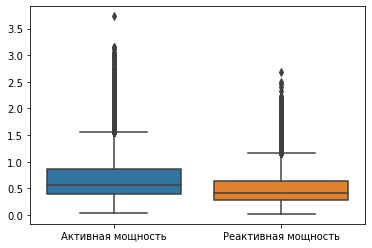

In [25]:
sns.boxplot(data = data_arc[data_arc['Реактивная мощность'] > -10].iloc[:, -2:]);

На бокс-плотах видно также наличие положительных выбросов. Сконструируем новый признак  - *полная мощность*, который равен корню из суммы квадратов активной и реактивной мощностей (в дальнейшем будем использовать его для моделирования). 

In [26]:
total_power = (data_arc['Активная мощность']**2 + data_arc['Реактивная мощность']**2) **0.5

Посмотрим на выбросы в новой переменной. 

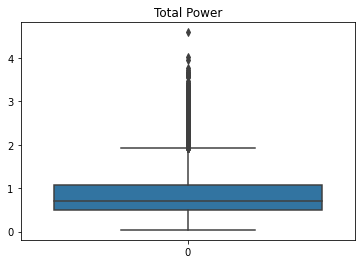

In [27]:
sns.boxplot(data = total_power[total_power < 10]);
plt.title('Total Power');

Очевидно, что в новой переменной также будут выбросы (поскольку это комбинация двух других переменных). Тем не менее проще удалять выбросы именно по одной переменной, чем сразу по нескольким (сделаем это в следующем спринте). 

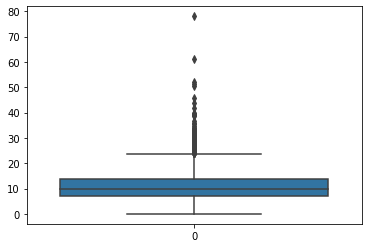

In [28]:
sns.boxplot(data = data_gas['Газ 1']);

В объеме газа также имеются выбросы, но их уже меньше, чем в предыдущей переменной. 

Посмотрим, имеются ли выбросы в первой и последней замеренной температурах.

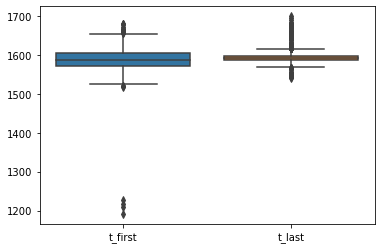

In [29]:
sns.boxplot(data = first_last_temp[['t_first', 't_last']]);

Выбросы есть и их много. Особенно бросаются в глаза точки для начальной температуры около 1200 градусов. Такие вещи точно следует удалить в дальнейшем. Посмотрим, как выглядят боксплоты без них.

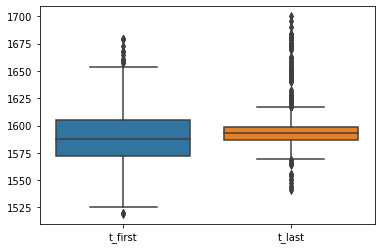

In [30]:
tem = first_last_temp[['t_first', 't_last']]
tem = tem[tem['t_first'] > 1500]

sns.boxplot(data = tem)

Выбросы все еще есть, особенно в целевой переменной. Такой разброс будет мешать моделированию и с этим придется что-то делать.

И наконец, посмотрим на распределение целевой переменной

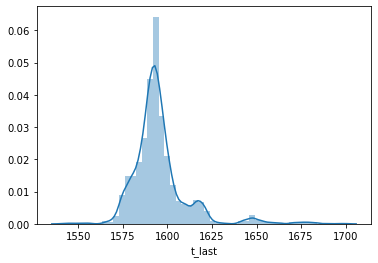

In [31]:
sns.distplot(first_last_temp.t_last);

Распределение островершинное по сравнению с нормальным, кроме того имеются небольшие холмики после значений температуры больше 1600.

## Удаление выбросов.

Начнем удаление выбросов с таблицы **first_last_temp**, потому что именно к ней мы в дальнейшем будем присоединять все остальные таблицы. 

Целиком и полностью ориентироваться на бокс-плот переменных мы не будем, поскольку в таком случае придется удалять слишком много значений. Кроме того выбросы могут быть информативными для бизнеса и поэтому, удаляя их бездумно, мы "кастрируем" нашу модель. Нам же в свою очередь хочется, чтобы модель умела прогнозировать значения разного диапозона, в том числе слишком большие и слишком маленькие. Поэтому условимся, что выбросом будут значения, выходящие за интервал 
(q25 - 3.1IQR; q75 + 3.1IQR). Такие значения однозначно будут анормальными и их следует удалить из выборки. Начнем с целевой переменной - последняя замерянная температура. 

In [32]:
def del_outliers(df, var, col = None):
    """
    
    Функция принимает на вход Датафрейм и название переменной в формате string.
    Возвращает Датафрейм без выбросов и строит бокс-плот.
    
    """
    q25 = df[var].quantile(0.25)
    q75 = df[var].quantile(0.75)
    IQR = q75 - q25
    left = q25 - 3.1 * IQR
    right = q75 + 3.1 * IQR
    new_df = df[(df[var] > left) & (df[var] < right)]
    sns.boxplot(data = new_df[var], color = col);
    plt.title(var)
    
    return new_df


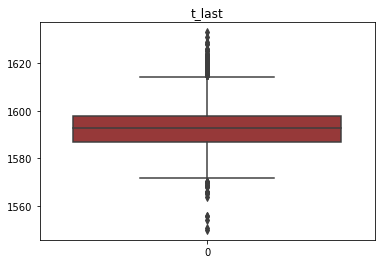

In [33]:
first_last_temp = del_outliers(first_last_temp, 't_last', col = 'brown')

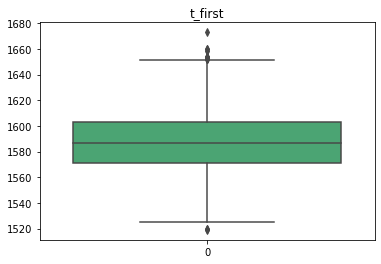

In [34]:
first_last_temp = del_outliers(first_last_temp, 't_first', col = 'mediumseagreen')

Мы удалили выбросы в таблице **first_last_temp**. Как видно из бокс-плотов, были удалены не все выбросы, однако чересчур аномальных значений в таблице больше нет. Всего из таблицы было удалено около 100 значений (было 2477).

In [35]:
len(first_last_temp) # длина новой таблицы без выбросов. 

2388

Прежде чем удалять выбросы в других таблицах, немного их почистим от уже ненужных значений. Напомню, что мы удалили много партий (key), которые нам не подходили (либо не было замера последней температуры, либо были ненужные выбросы). В остальных датафреймах оставим только те значения key, которые есть в таблице **first_last_temp**.

In [36]:
keys_temp = first_last_temp.key.unique() # ключи в итоговой таблице

data_arc = data_arc.query('key in @keys_temp')
data_bulk  = data_bulk.query('key in @keys_temp')
data_bulk_time = data_bulk_time.query('key in @keys_temp')
data_gas  = data_gas.query('key in @keys_temp')
data_wire = data_wire.query('key in @keys_temp')
data_wire_time = data_wire_time.query('key in @keys_temp')

Добавим новую переменную *total_power* в уже очищенную от лишних партий таблицу **data_arc**. Также добавим еще одну переменную *работа*, которая будет произведению полной мощности на разницу во времени между началом и концом нагрева дугой. Главным плюсом данной переменной является то, что работу можно складывать между собой (и это имеет физический смысл), соответственно, мы сможем посчитать суммарную работу для каждой партии в отдельности.

In [37]:
data_arc['total_power'] = (data_arc['Активная мощность']**2 + data_arc['Реактивная мощность']**2) **0.5
data_arc['time_diff'] = (data_arc['Конец нагрева дугой'] - data_arc['Начало нагрева дугой']).dt.total_seconds() # в секундах
data_arc['Работа'] = data_arc['time_diff'] * data_arc['total_power']

In [38]:
data_arc.head()

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,total_power,time_diff,Работа
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084,1.193639,228.0,272.149755
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285,0.959010,185.0,177.416785
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805,0.896038,172.0,154.118502
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669,1.970470,365.0,719.221394
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397,0.807239,148.0,119.471318


Просуммируем полученное значение работы по каждой партии. Полученные значения суммарной работы мы будем использовать как признак.

In [39]:
data_work = pd.pivot_table(data_arc, index = 'key', values = 'Работа', aggfunc = 'sum')
data_work.reset_index(inplace = True)

In [40]:
data_work.head()

,key,Работа
0,1,1442.377754
1,2,881.233565
2,3,525.066777
3,4,796.911309
4,5,1199.137958


На целевое значение температуры скорее всего будет в большей степени влиять значение total_power на последней итерации, поэтому вытащим его из таблицы **data_arc**.

In [41]:
data_arc_pivot = pd.pivot_table(data_arc, index = 'key', values = 'Начало нагрева дугой', aggfunc = 'max')
data_arc_pivot.reset_index(inplace = True)
data_last_total_power = pd.merge(data_arc_pivot, data_arc, on = 'Начало нагрева дугой', how = 'inner')
data_last_total_power = data_last_total_power[['key_x', 'Начало нагрева дугой', 'total_power']]
data_last_total_power.columns  = ['key', 'Начало нагрева дугой', 'total_power']

In [42]:
data_last_total_power.head()

,key,Начало нагрева дугой,total_power
0,1,2019-05-03 11:26:09,0.807239
1,2,2019-05-03 11:49:48,0.975867
2,3,2019-05-03 12:31:14,0.294865
3,4,2019-05-03 12:53:12,1.435385
4,5,2019-05-03 13:32:44,0.323503


Посмотрим на наличие возможных выбросов в признаке.

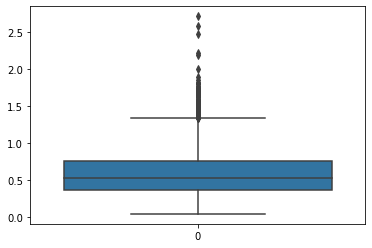

In [43]:
sns.boxplot(data = [data_last_total_power.total_power])

С помощью функции **del_outliers** удалим самые существенные выбросы.

In [44]:
print('Количество записей до удаления выбросов: ',len(data_last_total_power))

Количество записей до удаления выбросов:  2387


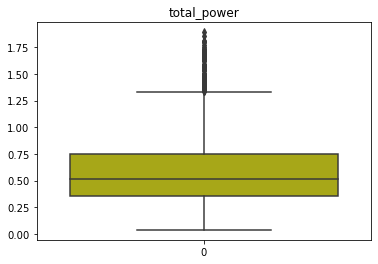

In [45]:
data_last_total_power = del_outliers(data_last_total_power, 'total_power', col = 'y')

In [46]:
print('Количество записей после удаления выбросов: ',len(data_last_total_power))

Количество записей после удаления выбросов:  2381


Теперь аналогично удалим аномальные значения в таблице с объемом газа.

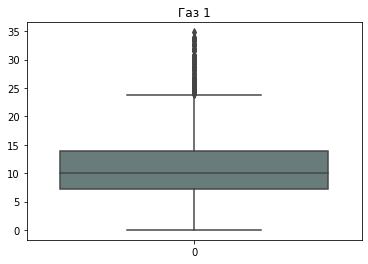

In [47]:
data_gas = del_outliers(data_gas, 'Газ 1', col = (0.4, 0.5, 0.5))

Разберемся с таблицами **data_wire и data_bulk**. В них содержится информации об объеме сыпучих веществ, которые подавались в каждую партию. Посмотрим, какой процент ненулевых значений имеется в таблице для каждого вещества. Чем больше ненулевых значений, тем больше материала подавалось в каждую из партий, тем больше влияние это вещество оказывало на конечную температуру.

In [48]:
pd.DataFrame(((data_wire > 0.01).sum() * 100 / len(data_wire))
             .sort_values(ascending = False),
             columns = ['Ненулевые значения, %'])

,"Ненулевые значения, %"
key,100.000000
Wire 1,99.026249
Wire 2,35.182049
Wire 6,1.693480
Wire 3,1.481795
Wire 9,1.185436
Wire 8,0.550381
Wire 4,0.338696
Wire 7,0.042337
Wire 5,0.000000


Оставим только wire1 и wire2.

In [49]:
data_wire = data_wire[['key','Wire 1', 'Wire 2']]

In [50]:
pd.DataFrame(((data_bulk > 0.01).sum() * 100 / len(data_bulk))
             .sort_values(ascending = False), 
            columns = ['Ненулевые значения, %'])

,"Ненулевые значения, %"
key,100.000000
Bulk 14,89.007699
Bulk 12,77.972626
Bulk 15,73.096664
Bulk 3,40.975192
Bulk 4,34.559453
Bulk 6,18.990590
Bulk 1,8.340462
Bulk 10,6.116339
Bulk 11,5.517536


Оставим только Bulk14, Bulk 12, Bulk 15, Bulk 3, Bulk 4

In [51]:
data_bulk = data_bulk[['key','Bulk 14', 'Bulk 12', 'Bulk 15', 'Bulk 3', 'Bulk 4']]

В таблицах **data_wire и data_bulk** все равно много нулевых значений, из-за этого скорее всего большая часть "реальных" значений объемов веществ будет считаться как выбросы. Мы сознательно оставим их, поскольку будущим моделям важно работать именно с такими значениями.

Теперь мы можем наконец-то собрать все наши предобработанные данные в одну итоговую таблицу. Сделаем это по столбцу *key*.

In [52]:
flt_bulk = pd.merge(first_last_temp, data_bulk, on = 'key', how = 'inner')
flt_bulk_wire = pd.merge(flt_bulk, data_wire, on = 'key', how = 'inner')
flt_bulk_wire_gas = pd.merge(flt_bulk_wire, data_gas, on = 'key', how = 'inner')
flt_bulk_wire_gas_power = pd.merge(flt_bulk_wire_gas, data_last_total_power, on = 'key', how = 'inner')
flt_bulk_wire_gas_power_work = pd.merge(flt_bulk_wire_gas_power, data_work, on = 'key', how = 'inner')

final_tab = flt_bulk_wire_gas_power_work.drop(['key','Первый замер','Последний замер', 'Начало нагрева дугой'], axis = 1)

In [53]:
final_tab

,t_first,t_last,Bulk 14,Bulk 12,Bulk 15,Bulk 3,Bulk 4,Wire 1,Wire 2,Газ 1,total_power,Работа
0,1571.0,1613.0,150.0,206.0,154.0,0.0,43.0,60.059998,0.00000,29.749986,0.807239,1442.377754
1,1581.0,1602.0,149.0,206.0,154.0,0.0,73.0,96.052315,0.00000,12.555561,0.975867,881.233565
2,1596.0,1599.0,152.0,205.0,153.0,0.0,34.0,91.160157,0.00000,28.554793,0.294865,525.066777
3,1601.0,1625.0,153.0,207.0,154.0,0.0,81.0,89.063515,0.00000,18.841219,1.435385,796.911309
4,1576.0,1602.0,151.0,203.0,152.0,0.0,78.0,89.238236,9.11456,5.413692,0.323503,1199.137958
...,...,...,...,...,...,...,...,...,...,...,...,...
2295,1570.0,1591.0,129.0,256.0,223.0,21.0,0.0,89.150879,0.00000,7.125735,0.531395,778.818234
2296,1554.0,1591.0,129.0,256.0,226.0,0.0,63.0,114.179527,0.00000,9.412616,1.262444,875.261419
2297,1571.0,1589.0,124.0,230.0,226.0,0.0,85.0,94.086723,9.04800,6.271699,1.025525,556.930349
2298,1591.0,1594.0,129.0,206.0,207.0,90.0,0.0,118.110717,0.00000,14.953657,0.214355,767.817794


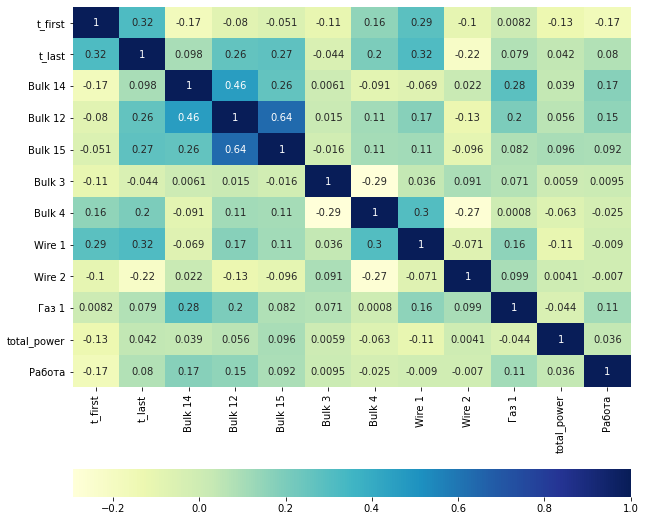

In [54]:
plt.figure(figsize = (10, 10))
sns.heatmap(final_tab.corr(), annot=True, cmap="YlGnBu",  cbar_kws={"orientation": "horizontal"})

На тепловой карте выше видно, что в целом между целевой переменной t_last и остальными переменными нет сильной линейной связи: самый высокий коэффициент корреляции по модулю составляет 0.32 (wire1 и t_first). Тем не менее это не значит, что зависимости между переменными нет, она может носить нелинейный характе. Среди независимых переменных умеренная корреляция наблюдается между Bulk12 и Bulk15 (0.64), а также между Bulk12 и Bulk14 (0.46). 

In [55]:
final_tab

,t_first,t_last,Bulk 14,Bulk 12,Bulk 15,Bulk 3,Bulk 4,Wire 1,Wire 2,Газ 1,total_power,Работа
0,1571.0,1613.0,150.0,206.0,154.0,0.0,43.0,60.059998,0.00000,29.749986,0.807239,1442.377754
1,1581.0,1602.0,149.0,206.0,154.0,0.0,73.0,96.052315,0.00000,12.555561,0.975867,881.233565
2,1596.0,1599.0,152.0,205.0,153.0,0.0,34.0,91.160157,0.00000,28.554793,0.294865,525.066777
3,1601.0,1625.0,153.0,207.0,154.0,0.0,81.0,89.063515,0.00000,18.841219,1.435385,796.911309
4,1576.0,1602.0,151.0,203.0,152.0,0.0,78.0,89.238236,9.11456,5.413692,0.323503,1199.137958
...,...,...,...,...,...,...,...,...,...,...,...,...
2295,1570.0,1591.0,129.0,256.0,223.0,21.0,0.0,89.150879,0.00000,7.125735,0.531395,778.818234
2296,1554.0,1591.0,129.0,256.0,226.0,0.0,63.0,114.179527,0.00000,9.412616,1.262444,875.261419
2297,1571.0,1589.0,124.0,230.0,226.0,0.0,85.0,94.086723,9.04800,6.271699,1.025525,556.930349
2298,1591.0,1594.0,129.0,206.0,207.0,90.0,0.0,118.110717,0.00000,14.953657,0.214355,767.817794


## Построение моделей.

Разделим выборку на тестовую и тренировочную. Будем строить три вида моделей: дерево решений, градиентный бустинг и случайный лес. Также проведем процедуру кросс-валидации на 5 фолдах, модель с лучшими параметрами будем использовать для предсказания.

In [56]:
df_train, df_test = train_test_split(final_tab, test_size = 0.25, random_state = 123)

In [57]:
X_train, X_test = df_train.drop('t_last', axis = 1), df_test.drop('t_last', axis = 1)
y_train, y_test = df_train.t_last, df_test.t_last

Посмотрим модель дерева решений.

In [58]:
dtr = DecisionTreeRegressor(random_state = 123)

parametrs = { 'max_depth': range (3,13, 2)}
grid = GridSearchCV(dtr, parametrs, scoring = 'neg_mean_absolute_error', cv=5)

In [59]:
grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(random_state=123),
             param_grid={'max_depth': range(3, 13, 2)},
             scoring='neg_mean_absolute_error')

In [60]:
pred_dtr = grid.predict(X_test)
mae_dtr_test = mae(y_test, pred_dtr)
print('Значение mae на тестовой выборке:', round(mae_dtr_test, 3))


Значение mae на тестовой выборке: 6.64


Построим модель градиентного бустинга.

In [61]:
gb = lgb.LGBMRegressor(random_state = 123)


params = {
    'max_depth': [7, 11, 13],
    'learning_rate': [0.01, 0.1, 0.4]
}

grid_gb = GridSearchCV(gb, params, scoring = 'neg_mean_absolute_error', cv=5)


In [62]:
grid_gb.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=LGBMRegressor(random_state=123),
             param_grid={'learning_rate': [0.01, 0.1, 0.4],
                         'max_depth': [7, 11, 13]},
             scoring='neg_mean_absolute_error')

In [63]:
predictions_gb = grid_gb.predict(X_test)
mae_gb_test = mae(y_test,predictions_gb)
print('Значение mae на тестовой выборке:', round(mae_gb_test, 3))

Значение mae на тестовой выборке: 5.802


И наконец построим модель случайного леса.

In [64]:
rf = RandomForestRegressor(random_state = 123)


params = {
    'max_depth': [7, 11, 13],
    'n_estimators': [100, 150, 200]
}

grid_rf = GridSearchCV(rf, params, scoring = 'neg_mean_absolute_error', cv=5)


In [65]:
grid_rf.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=123),
             param_grid={'max_depth': [7, 11, 13],
                         'n_estimators': [100, 150, 200]},
             scoring='neg_mean_absolute_error')

In [66]:
predictions_rf = grid_rf.predict(X_test)
mae_rf_test = mae(y_test,predictions_rf)
print('Значение mae на тестовой выборке:', round(mae_rf_test, 3))

Значение mae на тестовой выборке: 5.755


In [67]:
overal_results = pd.DataFrame({'MAE test' : [round(mae_dtr_test, 3), round(mae_gb_test, 3), round(mae_rf_test, 3)]},
                             index = ['Дерево решений', 'Градиентный бустинг', 'Случайный лес'])
overal_results

,MAE test
Дерево решений,6.640
Градиентный бустинг,5.802
Случайный лес,5.755


Мы проверили работу трех разных моделей, наилучшее значение mae на тестовой выборке показал случайный лес. Однако стоит заметить, что улучшение метрики по сравнению градиентным бустингом незначительное (разница в 0.05), а градиентный бустинг обучается намного быстрее, чем случайный лес. Так что бизнесу необходимо определиться, что ему важнее: доли точности или скорость работы модели. 

Будем считать, что случайный лес - лучшая модель. Посмотрим на то, какие переменные наиболее значимы в модели.

In [70]:
def importances(model, features):
    features=features.columns
    importances = model.best_estimator_.feature_importances_
    indices = np.argsort(importances)
    
    plt.figure(figsize=(11, 5))
    plt.title('Важность признаков')
    plt.barh(range(len(indices)), importances[indices], color='#6495ED', align='center')
    plt.yticks(range(len(indices)), features[indices])
    plt.xlabel('Относительная важность')
    plt.show()
        
    feat_importances = pd.Series(importances, index=features).sort_values(ascending=False)
    feat_importances = feat_importances.to_frame()
    feat_importances.columns=['Относительная важность']
    display(feat_importances)

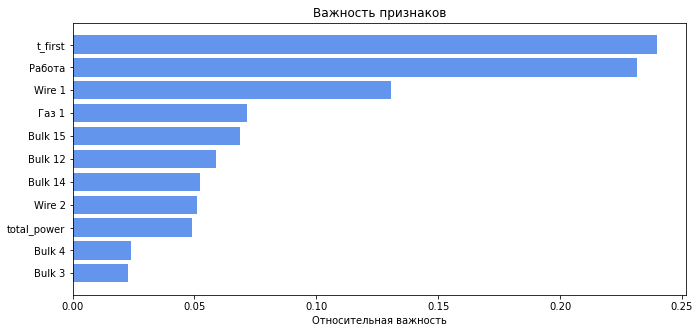

,Относительная важность
t_first,0.239810
Работа,0.231430
Wire 1,0.130522
Газ 1,0.071418
Bulk 15,0.068687
Bulk 12,0.058939
Bulk 14,0.052268
Wire 2,0.050978
total_power,0.049154
Bulk 4,0.023933


In [71]:
importances(grid_rf, X_test)

## Итоговый отчет по проекту

Перед нами стояла цель оптимизировать производственные расходы металлургического комбината ООО «Так закаляем сталь» на этапе обработки стали. Задача - построить модель машинного обучения, которая могла бы предсказывать температуру сплава на конечном этапе обработки (то есть перед разливом в слябы). Главной сложностью проекта было то, что данные находятся в 6 разных таблицах, причем целевого признака в явном виде не было. На первом этапе работы было необходимо сначала "вытащить" целевой признак (конечная температура), а затем уже к нему присоединять все остальные фичи. На этот этап у меня ушло больше всего времени.

Кроме того сами независимые признаки модели также не были даны в явном виде, поэтому пришлось некоторые из них агрегировать или создавать новые. Например, было создано два независимых признака - общая мощность (*total_power*) и суммарная работа (*Работа*). Стоит отметить, что общая мощность не сильно влияет на конечную температуру сплава, в отличии от суммарной работы, которая является второй по важности независимой переменной после начальной температуры сплава (*t_first*).

После объединения всех данных в одну таблицу мною были удалены выбросы из данных. Но тут стоит также пояснить, что удалялись только самые очевидные аномалии (которые выходили за рамки +/- 3.1 * IQR). Это было сделано сознательно для того, чтобы модель смогла обучиться и на слишком больших/маленьких значениях переменных, ведь они тоже могут быть важны для бизнеса, а без них модель будет "усеченной" и в боевых условиях не сможет адекватно сделать прогноз на подобных отклонениях.

И наконец, мы рассмотрели три модели: дерево решений, градиентный бустинг и случайный лес. Наилучшей моделью является модель случайного леса со значением MAE на тестовой выборке 5.755. Также мы оценили важность независимых переменных  Наиболее важными признаками являются изначальная температура и суммарная работа каждой отдельной парти, причем оба признака одинаково важны. К остальным значимым признакам можно отнести объем материала wire1, газа и Bulk15. Соответственно, бизнес в большей степени может управлять этими тремя показателями и тем самым влиять на конечную температуру и уменьшить потребление электроэнергии. В целом, все намеченные в начале шаги плана проекта были выполнены и с поставленной задачей мы справились. 
